# Bibliotecas

In [1]:
# Biblioteca padrão
import os
import sys
import time
import json
from importlib import reload  # (Descomente se necessário)
import random

# Bibliotecas de terceiros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from PIL import Image, ImageOps, ImageDraw
from scipy.optimize import curve_fit

# PyTorch e torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary
from torchvision import transforms, models
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision.transforms import ToTensor
from torchvision.transforms import functional as TF

# pycocotools
from pycocotools.coco import COCO

from sklearn.metrics import average_precision_score

# (Descomente se necessário)
# Get the parent directory of the current notebook file
from pathlib import Path
current_notebook_path = Path().resolve()  # Resolve the current working directory
parent_folder = current_notebook_path.parent

# Append the parent folder to sys.path
sys.path.append(str(parent_folder))
import minhas_funcoes


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Marlon\miniforge3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Marlon\miniforge3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Marlon\miniforge3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\Marlon\miniforge3\Lib\s

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))  # If there are multiple GPUs, this prints the first one


False
None


AssertionError: Torch not compiled with CUDA enabled

# 1 - Carregar modelo de estimação

In [5]:
# Inputs size
size_input = (224, 224)
size_heatmap = (56, 56)

# Modelo
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

# Modifica ultima layer
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 17 * size_heatmap[0] * size_heatmap[1]),
    torch.nn.Unflatten(1, (17, size_heatmap[0], size_heatmap[1]))
)

print(f"Modelo não treinado inicializado.")

model_path = "modelo_base_fc_estimator.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

best_epoch = checkpoint['epoch']
best_loss = checkpoint['val_loss']

print(f"Pesos carregados.")

print(f"Melhor época: {best_epoch}")
print(f"Melhor loss: {best_loss:.6f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model is on {device}")

Modelo não treinado inicializado.


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# 2 - Carregar modelo de detecção

In [3]:
# Primeiro o modelo é inicializado
weights_detector = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model_detector = fasterrcnn_resnet50_fpn(weights=weights_detector)

print(f"Modelo detector inicializado.")

# Carrega os pesos
checkpoint_detector = torch.load(r"C:\Users\Marlon\Nextcloud2\Code_Pose_Estimation\detector_treinado\best_model_faster_rcnn_25_epocas_treinadas_best_at_22.pth")
model_detector.load_state_dict(checkpoint_detector['model_state_dict'])

# Passa o modelo p/ GPU se disponível
device_detector = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_detector.to(device_detector)
print(f"Model is on {device_detector}")

# Set the model to evaluation mode
model_detector.eval()
print(f"Detector treinado carregado.")

Modelo detector inicializado.


C:\Users\Marlon\AppData\Local\Temp\ipykernel_5656\2466510626.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_detector = torch.load(r"C:\Users\Marlon\Nextcloud

Model is on cuda
Detector treinado carregado.


# 3 - Classe usada para estimador

In [4]:
class COCOPoseDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, valid_samples, target_size=(256, 256), heatmap_size=(64, 64)):
        self.image_dir = image_dir
        self.coco = COCO(annotations_file)
        self.valid_samples = valid_samples
        self.target_size = target_size  # (h, w)
        self.heatmap_size = heatmap_size  # (h, w)

    def __len__(self):
        return len(self.valid_samples)

    def create_gaussian_heatmap(self, height, width, center_x, center_y, sigma=2):
        x_grid, y_grid = np.meshgrid(np.arange(width), np.arange(height))
        d2 = (x_grid - center_x) ** 2 + (y_grid - center_y) ** 2
        gaussian = np.exp(-d2 / (2 * sigma ** 2))
        return gaussian

    def __getitem__(self, idx):
        # Get image_id and bbox
        image_id, bbox = self.valid_samples[idx]
        x_min, y_min, x_max, y_max = bbox # Acredito que essa bbox sempre seja válida   

        # Load image
        image_path = os.path.join(self.image_dir, self.coco.loadImgs(image_id)[0]['file_name'])
        image = Image.open(image_path).convert("RGB")

        # Crop and resize image
        image_cropped = image.crop((x_min, y_min, x_max, y_max))
        aspect_ratio = image_cropped.height / image_cropped.width
        print(f"Aspect ratio {aspect_ratio}")# DEBUG
        if aspect_ratio > 1:
            new_height = self.target_size[0]
            new_width = int(self.target_size[1] / aspect_ratio)
        else:
            new_width = self.target_size[1]
            new_height = int(self.target_size[0] * aspect_ratio)
        image_resized = image_cropped.resize((new_width, new_height), Image.LANCZOS)
        print(f"Resized image size: {image_resized.size}")# DEBUG

        # Pad the image
        delta_h = max(0, self.target_size[0] - new_height)
        delta_w = max(0, self.target_size[1] - new_width)
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        print(f"Padding: {padding}")# DEBUG
        image_padded = ImageOps.expand(image_resized, padding, fill=(0, 0, 0))
        print(f"Padded image size: {image_padded.size}")

        # Adjust keypoints
        ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=[self.coco.getCatIds(catNms=['person'])[0]], iscrowd=False)
        annotations = self.coco.loadAnns(ann_ids)
        keypoints = annotations[0]['keypoints']
        keypoints = [(keypoints[i], keypoints[i + 1], keypoints[i + 2]) for i in range(0, len(keypoints), 3)]
        adjusted_keypoints = [(x - x_min, y - y_min, v) for x, y, v in keypoints]
        scale_x, scale_y = new_width / (x_max - x_min), new_height / (y_max - y_min)
        scaled_keypoints = [(x * scale_x, y * scale_y, v) for x, y, v in adjusted_keypoints]
        adjusted_keypoints_padded = [(x + padding[0], y + padding[1], v) for x, y, v in scaled_keypoints]

        # Generate heatmaps
        scale_y_hm = self.heatmap_size[0] / self.target_size[0]
        scale_x_hm = self.heatmap_size[1] / self.target_size[1]
        heatmaps = []
        for x, y, v in adjusted_keypoints_padded:
            if v == 2:
                x_hm, y_hm = int(x * scale_x_hm), int(y * scale_y_hm)
                heatmap = self.create_gaussian_heatmap(self.heatmap_size[0], self.heatmap_size[1], x_hm, y_hm, sigma=2)
            else:
                heatmap = np.zeros(self.heatmap_size)
            heatmaps.append(torch.tensor(heatmap))

        # Convert image to tensor
        image_tensor = torch.tensor(np.array(image_padded)).permute(2, 0, 1) / 255.0
        heatmaps_tensor = torch.stack(heatmaps)
        
        img_resized_values = np.array(image_resized)
        img_padded_values = np.array(image_padded)
        return image_tensor, heatmaps_tensor, adjusted_keypoints_padded, img_padded_values, padding, img_resized_values, bbox, (image.width, image.height)


# Assuming the same keypoint_names list as before
keypoint_names = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear", 
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", 
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip", 
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

# 4 - Imagens selecionadas para teste

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


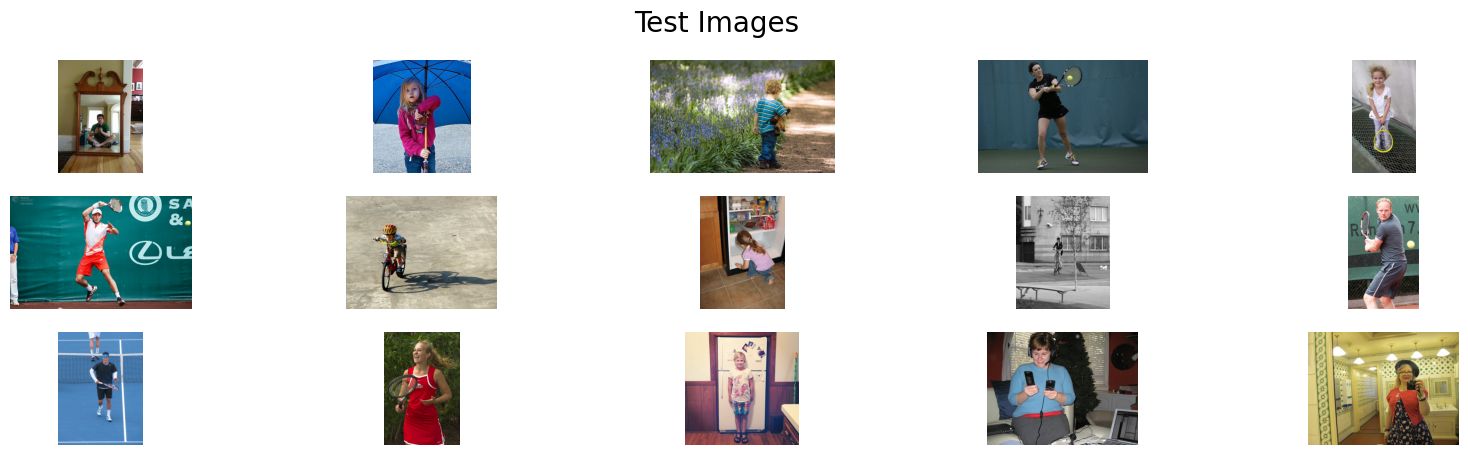

In [5]:
ann_file = r"c:\Users\Marlon\Downloads\annotations\annotations\person_keypoints_val2017.json"
val_imgs_dir = r"C:\Users\Marlon\Downloads\val2017"
coco = COCO(ann_file)

easy_imgs_dir = r"C:\Users\Marlon\Nextcloud2\Code_Pose_Estimation\imagens_teste\easy"

# Path das imagens selecionadas
# Nesses dicts os nomes dos arquivos são as keys e os values as anotações extraídas do COCO
easy_imgs = minhas_funcoes.create_annotation_dict(ann_file, easy_imgs_dir)

# Preciso de uma lista de IDs
easy_imgs_ids = []
for key, value in easy_imgs.items():
    easy_imgs_ids.append(value['annotations'][0]['image_id'])
    
# Iterar cada elemento dos dicts, e para cada um exibir a imagem

# # Easy
key_easy = list(easy_imgs.keys())
    
fig, axes = plt.subplots(3, 5, figsize=(20, 5))

for i in range(15):
    row = i // 5
    col = i % 5
    key = key_easy[i]
    img = Image.open(os.path.join(easy_imgs_dir, key))
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

fig.suptitle("Test Images", fontsize=20)
plt.show() 

In [6]:
print(easy_imgs_ids)
print(key_easy)

[5060, 9448, 50638, 65736, 117744, 152686, 210299, 231339, 289343, 328601, 372577, 386879, 456662, 537991, 561256]
['000000005060.jpg', '000000009448.jpg', '000000050638.jpg', '000000065736.jpg', '000000117744.jpg', '000000152686.jpg', '000000210299.jpg', '000000231339.jpg', '000000289343.jpg', '000000328601.jpg', '000000372577.jpg', '000000386879.jpg', '000000456662.jpg', '000000537991.jpg', '000000561256.jpg']


## 4.1 Carregar imagens para a detecção
Load a dataset with just the testing images. And then initiate a dataloader with a batch size of 1.

In [7]:
transform = ToTensor()

# Create the dataset
dataset_easy = minhas_funcoes.PersonDetectionDataset(
    img_ids=easy_imgs_ids,
    annotations_file=ann_file,
    image_dir=easy_imgs_dir,
    transform=transform
    )

data_loader_easy = DataLoader(
    dataset_easy,
    batch_size=1,  # Increase if GPU memory allows
    shuffle=False,    
    # collate_fn=lambda x: tuple(zip(*x))  # Necessary for variable-sized detection data
)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


## 4.2 Plot resulting detections.

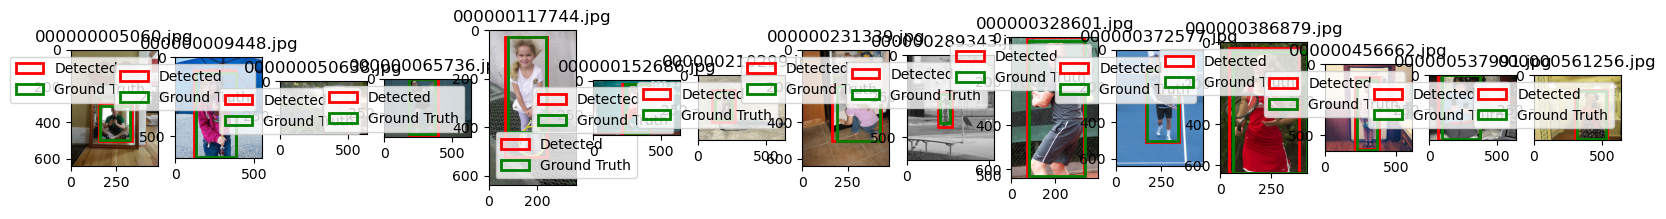

In [8]:
# Gerar saídas para cada uma das imagens selecionadas
all_batches = list(data_loader_easy)
outputs = []

for i, batch in enumerate(all_batches):
    with torch.no_grad():
        image, target = batch    
        image = image.to(device_detector)            
        output = model_detector(image)
        outputs.append((output, target))
        
fig, axes = plt.subplots(1, 15, figsize=(20, 5))
valid_samples_easy = []

for i, ax in enumerate(axes):
    # IMG
    key = key_easy[i]
    img_id = outputs[i][1]['image_id']
    img_id = int(img_id)
    
    img = Image.open(os.path.join(easy_imgs_dir, key))
    ax.imshow(img)
    ax.set_title(key)
    
    # BBOX gerada
    bbox_tensor = outputs[i][0][0]['boxes'][0]
    bbox_det = [int(b) for b in bbox_tensor.cpu().numpy()]
    width = img.width
    height = img.height
    bbox_det = minhas_funcoes.add_symmetric_padding_to_box(box=bbox_det, padding_percentage=2, image_width=width, image_height=height)    
    
    valid_samples_easy.append((img_id, bbox_det))
    
    det_rect = patches.Rectangle(
        (bbox_det[0], bbox_det[1]),  # (x_min, y_min)
        bbox_det[2] - bbox_det[0],  # width
        bbox_det[3] - bbox_det[1],  # height
        linewidth=2,
        edgecolor="red",
        facecolor="none",
        label="Detected"
    )
    ax.add_patch(det_rect)
    
    # BBOX GT
    bbox_gt_tensor = outputs[i][1]['boxes']
    bbox_gt = [int(x) for x in bbox_gt_tensor[0][0].tolist()]
    
    gt_rect = patches.Rectangle(
        (bbox_gt[0], bbox_gt[1]),  # (x_min, y_min)
        bbox_gt[2] - bbox_gt[0],  # width
        bbox_gt[3] - bbox_gt[1],  # height
        linewidth=2,
        edgecolor="green",
        facecolor="none",
        label="Ground Truth"
    )
    ax.add_patch(gt_rect)
    
    # Adicionar a legenda
    ax.legend()


## 4.3 Carregar dataset para o estimador

In [9]:
size_input = (224, 224)
size_heatmap = (56, 56)

dataset_easy_final = COCOPoseDataset(image_dir=easy_imgs_dir, annotations_file=ann_file, valid_samples=valid_samples_easy, target_size=size_input, heatmap_size=size_heatmap)

data_loader_easy_final = DataLoader(dataset_easy_final, batch_size=1)
data_loader_easy_final_batches = list(data_loader_easy_final)

# Lembrando que cada elemento do meu batch tem isso aqui que estou retornando
# return image_tensor, heatmaps_tensor, adjusted_keypoints_padded, image_padded_values
# E model é o nome do modelo de estimação


loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Aspect ratio 1.145945945945946
Resized image size: (195, 224)
Padding: (14, 0, 15, 0)
Padded image size: (224, 224)
Aspect ratio 2.093984962406015
Resized image size: (106, 224)
Padding: (59, 0, 59, 0)
Padded image size: (224, 224)
Aspect ratio 2.0636942675159236
Resized image size: (108, 224)
Padding: (58, 0, 58, 0)
Padded image size: (224, 224)
Aspect ratio 1.9953271028037383
Resized image size: (112, 224)
Padding: (56, 0, 56, 0)
Padded image size: (224, 224)
Aspect ratio 2.8497109826589595
Resized image size: (78, 224)
Padding: (73, 0, 73, 0)
Padded image size: (224, 224)
Aspect ratio 1.8195121951219513
Resized image size: (123, 224)
Padding: (50, 0, 51, 0)
Padded image size: (224, 224)
Aspect ratio 1.3647058823529412
Resized image size: (164, 224)
Padding: (30, 0, 30, 0)
Padded image size: (224, 224)
Aspect ratio 1.1592592592592592
Resized image size: (193, 224)
Padding: (15, 0, 16, 0)
Padded image s

## 6.5 Inputs usadas do modelo de estimação
Essas imagens foram cortadas utilizando a bounding box do detector, e então redimensionadas para o tamanho da input do modelo de estimação.

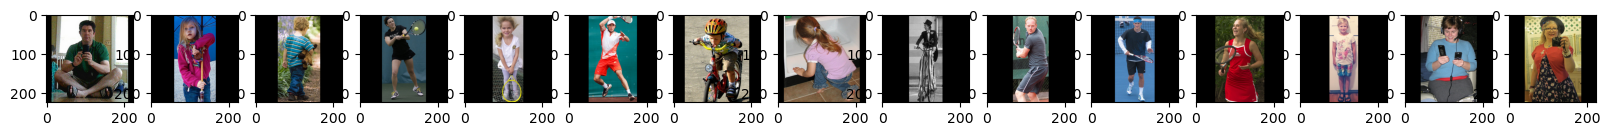

In [10]:
# Importante estar ciente de que a classe usada para testes é modificada, ela retorna:
# return image_tensor, heatmaps_tensor, adjusted_keypoints_padded, img_padded_values, padding, (new_width, new_height), bbox, (image.width, image.height)

img_tensors_easy = []
heatmaps_tensors_easy = []
keypoints_easy = []
image_padded_values_easy = []
paddings_easy = []
img_resized_easy = [] # Resized image after cropping, but without padding
bbox_crops_easy = []
original_sizes_easy = []
# resized_img

for i in range(len(data_loader_easy_final_batches)):
    img_tensor, heatmaps_tensor, keypoints, image_padded, padding, resized_img, bbox_crop, original_size  = data_loader_easy_final_batches[i]
    img_tensors_easy.append(img_tensor)
    heatmaps_tensors_easy.append(heatmaps_tensor)
    keypoints_easy.append(keypoints)
    image_padded_values_easy.append(image_padded.squeeze(0))
    paddings_easy.append(padding)
    img_resized_easy.append(resized_img)
    bbox_crops_easy.append(bbox_crop)
    original_sizes_easy.append(original_size)
    
# Para análise, visualizar as imagens cortadas e transformadas passadas para o modelo de estimação
fig, axes = plt.subplots(1, 15, figsize=(20, 5))

for i, ax in enumerate(axes):
    ax.imshow(image_padded_values_easy[i])
    
# Passar de tensor para list/int
img_resized_easy = [img.squeeze(0).cpu().numpy() for img in img_resized_easy]


## 6.6 Outputs modelo de estimação 

Gerar outputs.

In [11]:
outputs_easy = []

for i in range(len(img_tensors_easy)):
    with torch.no_grad():
        img_tensor = img_tensors_easy[i].to(device_detector)
        output = model(img_tensor)
        outputs_easy.append(output)
        
print(outputs_easy[0].shape)


torch.Size([1, 17, 56, 56])


## 6.7 Imagem 1

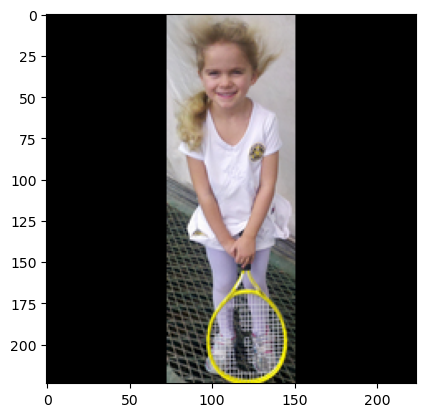

In [12]:
# Plot the image
n_image = 4
plt.imshow(image_padded_values_easy[n_image])

# Heatmap saída e gt para recuperar a visiblidade
# Convert tensors to numpy arrays for easier handling
predicted_heatmaps = outputs_easy[n_image].squeeze(0).cpu().numpy()  # Shape: (17, 64, 56)
ground_truth_heatmaps = heatmaps_tensors_easy[n_image].squeeze(0).cpu().numpy()  # Shape: (17, 64, 56)
ground_truth_keypoints = np.array(keypoints_easy[n_image])  # (17, 3)
ground_truth_visibility = ground_truth_keypoints[:, 2]

### 4.10.1 Output x Ground-truth (Argmax) (64,56)

In [13]:
# minhas_funcoes.plot_keypoint_heatmaps(
#     predicted_heatmaps, 
#     ground_truth_heatmaps, 
#     ground_truth_visibility, 
#     keypoint_names, 
#     input_image=None, 
#     point_extraction_method="argmax", 
#     scale_to_input_image=False
# )

### 4.10.3 Outputs x Ground-truth (Argmax) (224, 224)

C:\Users\Marlon\Nextcloud2\Code_Pose_Estimation\minhas_funcoes.py:568: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)
C:\Users\Marlon\Nextcloud2\Code_Pose_Estimation\minhas_funcoes.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


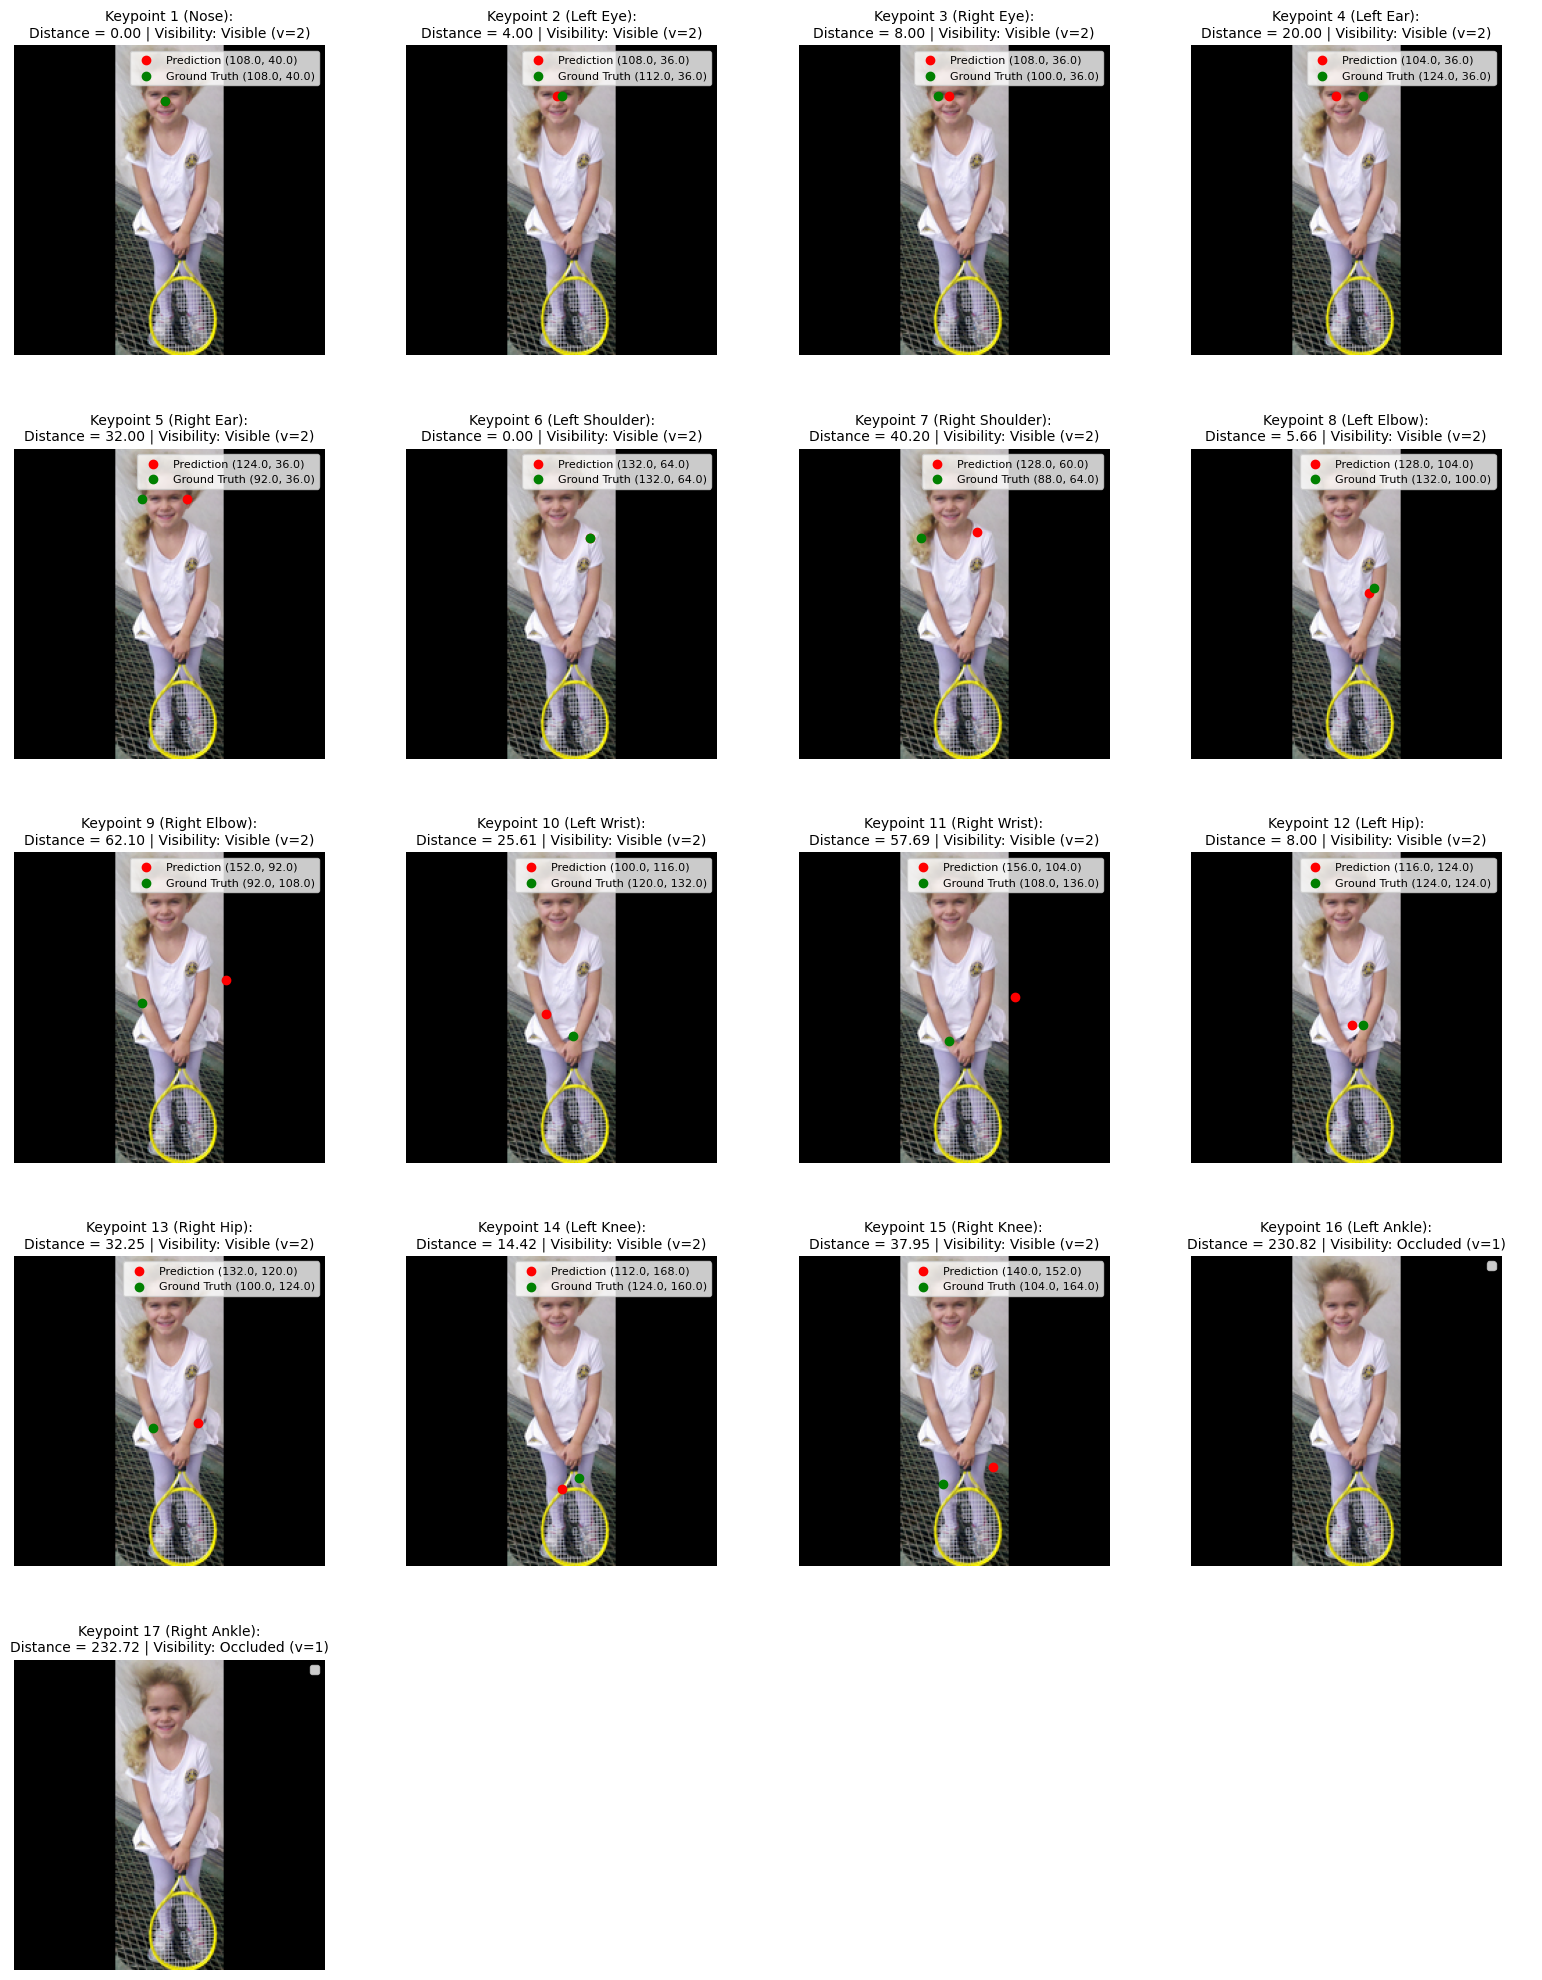

In [14]:
minhas_funcoes.plot_keypoint_heatmaps(
    predicted_heatmaps=predicted_heatmaps,
    ground_truth_heatmaps=ground_truth_heatmaps,
    ground_truth_visibility=ground_truth_visibility,
    keypoint_names=keypoint_names,
    input_image=image_padded_values_easy[n_image].cpu().numpy(),
    point_extraction_method="argmax",
    scale_to_input_image=True
)

In [15]:
def extract_keypoints_from_heatmaps(heatmaps, original_width=224, original_height=224):
    """
    Extract (x,y) coordinates for each keypoint from the given heatmaps and scale them 
    back to the original input image size.

    Parameters
    ----------
    heatmaps : torch.Tensor
        A tensor of shape (batch_size, num_keypoints, H, W) containing the heatmaps 
        for each keypoint.
    
    original_width : int, optional
        The width of the input images to the model.
        
    original_height : int, optional
        The height of the input images to the model.

    Returns
    -------
    predictions : list
        A list (length = batch_size) where each element is a list of dictionaries.
        Each dictionary corresponds to one keypoint and has the keys:
        - 'x': x-coordinate of the keypoint in the original image space
        - 'y': y-coordinate of the keypoint in the original image space
    """

    # Move heatmaps to CPU if they are on GPU, and convert to numpy
    if heatmaps.is_cuda:
        heatmaps = heatmaps.cpu()
    heatmaps_np = heatmaps.detach().numpy()  # shape: (B, K, H, W)

    batch_size, num_keypoints, H, W = heatmaps_np.shape
    predictions = []

    # Compute scaling factors
    scale_x = original_width / float(W)
    scale_y = original_height / float(H)
    
    if batch_size == 1:
        for k in range(num_keypoints):
            # Extract keypoint heatmap
            kp_heatmap = heatmaps_np[0, k, :, :]

            # Find the index of the maximum value
            idx = np.argmax(kp_heatmap)
            y_hm = idx // W
            x_hm = idx % W

            # Scale coordinates back to original image size
            x_orig = x_hm * scale_x
            y_orig = y_hm * scale_y

            kp_predictions_out = (float(x_orig), float(y_orig))
            predictions.append(kp_predictions_out)
    else:
        for b in range(batch_size):
            sample_predictions = []
            for k in range(num_keypoints):
                # Extract keypoint heatmap
                kp_heatmap = heatmaps_np[b, k, :, :]

                # Find the index of the maximum value
                idx = np.argmax(kp_heatmap)
                y_hm = idx // W
                x_hm = idx % W

                # Scale coordinates back to original image size
                x_orig = x_hm * scale_x
                y_orig = y_hm * scale_y

                kp_predictions_out = (float(x_orig), float(y_orig))
                sample_predictions.append(kp_predictions_out)
            predictions.append(sample_predictions)

    return predictions

Predicted keypoints are dicts {'x': value_1, 'y': value_2}.

In [16]:
predicted_points = extract_keypoints_from_heatmaps(outputs_easy[0], original_width=224, original_height=224)

# Lets turn this into an array for easier handling
predicted_points = np.array(predicted_points)
print(predicted_points)


[[104.  52.]
 [108.  44.]
 [ 96.  44.]
 [116.  48.]
 [ 84.  44.]
 [128.  80.]
 [ 72.  80.]
 [148. 128.]
 [ 60. 124.]
 [120. 136.]
 [ 68. 108.]
 [136. 172.]
 [ 88. 168.]
 [132. 208.]
 [ 44. 128.]
 [112. 192.]
 [156. 176.]]


Lets reshape the ground truth points.

In [17]:
ground_truth_keypoints = np.array(keypoints_easy[n_image])  # (17, 3)
ground_truth_visibility = ground_truth_keypoints[:, 2]

gt_kps_reshape = []
for pt in ground_truth_keypoints:
    gt_kps_reshape.append((float(pt.item(0)), float(pt.item(1)), float(pt.item(2))))  
gt_kps_reshape = np.array(gt_kps_reshape)  
print(gt_kps_reshape)

[[108.16763006  43.1643002    2.        ]
 [114.93063584  36.34888438   2.        ]
 [101.40462428  36.34888438   2.        ]
 [125.30057803  38.1663286    2.        ]
 [ 93.28901734  39.52941176   2.        ]
 [132.06358382  64.51926978   2.        ]
 [ 91.48554913  66.79107505   2.        ]
 [134.31791908 102.68559838   2.        ]
 [ 95.09248555 109.5010142    2.        ]
 [123.04624277 134.94523327   2.        ]
 [109.97109827 137.67139959   2.        ]
 [127.55491329 125.85801217   2.        ]
 [101.85549133 127.67545639   2.        ]
 [127.55491329 163.56997972   2.        ]
 [105.9132948  164.47870183   2.        ]
 [129.80924855 194.46653144   1.        ]
 [106.8150289  195.8296146    1.        ]]


Now, both are in a similar shape, predictions = (x,y), and gt = (x,y,v).

In [18]:
def compute_mpjpe(predictions, ground_truths, visibility_threshold=1):
    """
    Compute the Mean Per Joint Position Error (MPJPE) between predicted and ground truth keypoints.
    
    Parameters
    ----------
    predictions : np.ndarray
        Array of shape (N, 2) with predicted keypoints [(x_pred, y_pred), ...].
        
    ground_truths : np.ndarray
        Array of shape (N, 3) with ground truth keypoints [(x_gt, y_gt, v), ...].
        v indicates visibility, where typically:
          - v = 2: keypoint fully visible
          - v = 1: keypoint labeled but not visible (occluded)
          - v = 0: keypoint not labeled (absent or outside image)
    
    Returns
    -------
    mpjpe : float
        The mean per joint position error (in the same units as your coordinates, e.g., pixels).
        Returns np.nan if no visible keypoints meet the criterion.
    """

    # Filter keypoints by visibility
    visible_mask = ground_truths[:, 2] > visibility_threshold
    visible_gt = ground_truths[visible_mask, :2]  # Take only (x,y)
    visible_pred = predictions[visible_mask, :]

    if len(visible_gt) == 0:
        # No keypoints meet the visibility criterion
        return np.nan

    # Compute Euclidean distances per keypoint
    errors = np.sqrt(np.sum((visible_pred - visible_gt) ** 2, axis=1))

    # Mean error (MPJPE)
    mpjpe = np.mean(errors)
    return mpjpe

# Example usage:
mpjpe_value = compute_mpjpe(predicted_points, gt_kps_reshape)
print("MPJPE:", mpjpe_value)


MPJPE: 28.018552651877418


# MPJPE for all images

In [19]:
all_mpjpe_values = []

for i in range(len(outputs_easy)):
    predicted_points = extract_keypoints_from_heatmaps(outputs_easy[i], original_width=224, original_height=224)
    predicted_points = np.array(predicted_points)
    
    ground_truth_raw = np.array(keypoints_easy[i])  # shape (17, 3)
    gt_kps = []
    for pt in ground_truth_raw:
        gt_kps.append((float(pt.item(0)), float(pt.item(1)), float(pt.item(2))))  
    gt_kps = np.array(gt_kps)
    
    mpjpe_value = compute_mpjpe(predicted_points, gt_kps)
    print(f"{key_easy[i]} - MPJPE: {mpjpe_value:.4f}")
    all_mpjpe_values.append(mpjpe_value)

# Now compute the average MPJPE across all images
mean_mpjpe = np.mean(all_mpjpe_values)
print(f"Mean MPJPE across all images: {mean_mpjpe}")


000000005060.jpg - MPJPE: 16.6623
000000009448.jpg - MPJPE: 35.8319
000000050638.jpg - MPJPE: 25.5558
000000065736.jpg - MPJPE: 11.0799
000000117744.jpg - MPJPE: 23.6558
000000152686.jpg - MPJPE: 18.6093
000000210299.jpg - MPJPE: 41.6854
000000231339.jpg - MPJPE: 38.1804
000000289343.jpg - MPJPE: 22.5500
000000328601.jpg - MPJPE: 26.6664
000000372577.jpg - MPJPE: 27.8202
000000386879.jpg - MPJPE: 28.0436
000000456662.jpg - MPJPE: 8.2055
000000537991.jpg - MPJPE: 45.4358
000000561256.jpg - MPJPE: 49.1004
Mean MPJPE across all images: 27.938848318287903


In [21]:
def save_mpjpe_to_spreadsheet(spreadsheet_path, image_filenames, mpjpe_values):
    """
    Save image filenames and their corresponding MPJPE values to a spreadsheet with two columns.
    
    Parameters
    ----------
    spreadsheet_path : str
        Path to the Excel spreadsheet file to be saved (e.g., 'mpjpe_baseline_fc.xlsx').
    image_filenames : list of str
        List of image filenames (e.g., ['000000005060.jpg', '000000009448.jpg', ...]).
    mpjpe_values : list of float
        List of MPJPE values corresponding to the image filenames (e.g., [16.6623, 35.8319, ...]).
    
    Returns
    -------
    None
    """
    
    # Check if the lengths of the lists match
    if len(image_filenames) != len(mpjpe_values):
        raise ValueError("The number of image filenames must match the number of MPJPE values.")
    
    # Create a DataFrame with the data
    df = pd.DataFrame({
        'Image Filename': image_filenames,
        'MPJPE': mpjpe_values
    })
    
    # Save the DataFrame to an Excel file
    try:
        df.to_excel(spreadsheet_path, index=False, engine='openpyxl')
        print(f"MPJPE values successfully saved to '{spreadsheet_path}'.")
    except Exception as e:
        print(f"An error occurred while saving to the spreadsheet: {e}")

In [22]:
# # Define the path where you want to save the spreadsheet
# spreadsheet_path = r'c:\Users\Marlon\Nextcloud2\Code_Pose_Estimation\mpjpe_baseline_fc.xlsx'

# # Call the function to save the data
# save_mpjpe_to_spreadsheet(spreadsheet_path, key_easy, all_mpjpe_values)

# PCK

In [23]:
# For start we will take the points from the first image on our test set
n_image = 2

# Those are our gt points
ground_truth_keypoints_raw = np.array(keypoints_easy[n_image])  # (17, 3)
gt_points = []
for pt in ground_truth_keypoints_raw:
    gt_points.append((float(pt.item(0)), float(pt.item(1)), float(pt.item(2))))  
gt_points = np.array(gt_points)  

# And those are the predicted points
predicted_points = extract_keypoints_from_heatmaps(outputs_easy[n_image], original_width=224, original_height=224)
predicted_points = np.array(predicted_points)

# Images names are stored in the list key_easy

In [35]:
def save_pck_to_spreadsheet(spreadsheet_path, image_filenames, pck_values):
    """
    Save image filenames and their corresponding PCK values to a spreadsheet with two columns.
    """
    if len(image_filenames) != len(pck_values):
        raise ValueError("The number of image filenames must match the number of PCK values.")
    
    df = pd.DataFrame({
        'Image Filename': image_filenames,
        'PCK': pck_values
    })
    
    try:
        df.to_excel(spreadsheet_path, index=False, engine='openpyxl')
        print(f"PCK values successfully saved to '{spreadsheet_path}'.")
    except Exception as e:
        print(f"An error occurred while saving to the spreadsheet: {e}")

# Torso will be our main reference length
def compute_torso_length(ground_truth):
    """
    Compute the torso length from ground truth keypoints.

    Parameters:
    ----------
    ground_truth : np.ndarray
        Array of shape (K, 3) with ground truth keypoints [(x_gt, y_gt, v), ...].
        K is the number of keypoints.

    Returns:
    -------
    torso_length : float
        Euclidean distance between mid-hip and mid-shoulder.
        Returns np.nan if required keypoints are not visible.
    """
    # Define keypoint indices based on COCO format
    LEFT_SHOULDER = 5
    RIGHT_SHOULDER = 6
    LEFT_HIP = 11
    RIGHT_HIP = 12
    
    # Extract keypoints
    left_shoulder = ground_truth[LEFT_SHOULDER]
    right_shoulder = ground_truth[RIGHT_SHOULDER]
    left_hip = ground_truth[LEFT_HIP]
    right_hip = ground_truth[RIGHT_HIP]
    
    # Check visibility
    if (left_shoulder[2] <= 0 or right_shoulder[2] <= 0 or
        left_hip[2] <= 0 or right_hip[2] <= 0):
        return np.nan
    
    # Compute midpoints
    mid_shoulder = np.array([(left_shoulder[0] + right_shoulder[0]) / 2,
                             (left_shoulder[1] + right_shoulder[1]) / 2])
    mid_hip = np.array([(left_hip[0] + right_hip[0]) / 2,
                        (left_hip[1] + right_hip[1]) / 2])
    
    # Compute Euclidean distance
    torso_length = np.linalg.norm(mid_shoulder - mid_hip)
    
    return torso_length

# We will have head size as only fallback, if torso is not visible
def compute_head_size(ground_truth):
    """
    Compute the head size from ground truth keypoints as inter-eye distance.

    Parameters:
    ----------
    ground_truth : np.ndarray
        Array of shape (K, 3) with ground truth keypoints [(x_gt, y_gt, v), ...].

    Returns:
    -------
    head_size : float
        Euclidean distance between left and right eyes.
        Returns np.nan if required keypoints are not visible.
    """
    LEFT_EYE = 1
    RIGHT_EYE = 2
    
    left_eye = ground_truth[LEFT_EYE]
    right_eye = ground_truth[RIGHT_EYE]
    
    if left_eye[2] <= 0 or right_eye[2] <= 0:
        return np.nan
    
    eye_distance = np.linalg.norm(left_eye[:2] - right_eye[:2])
    
    return eye_distance


def compute_reference_length(ground_truth, method='torso'):
    """
    Compute the reference length based on the chosen method.

    Parameters:
    ----------
    ground_truth : np.ndarray
        Array of shape (K, 3) with ground truth keypoints [(x_gt, y_gt, v), ...].
    method : str, optional
        Method to compute reference length. Options: 'torso', 'head', 'bbox', 'limbs'.
        Default is 'torso'.

    Returns:
    -------
    reference_length : float
        Computed reference length.
    """
    if method == 'torso':
        return compute_torso_length(ground_truth)
    elif method == 'head':
        return compute_head_size(ground_truth)
    else:
        raise ValueError("Invalid method for reference length.")

def compute_pck(predictions, ground_truths, reference_length, threshold=0.2, visibility_threshold=0):
    """
    Compute the Percentage of Correct Keypoints (PCK).
    
    Parameters
    ----------
    predictions : np.ndarray
        Array of shape (N, 2) with predicted keypoints [(x_pred, y_pred), ...].
        
    ground_truths : np.ndarray
        Array of shape (N, 3) with ground truth keypoints [(x_gt, y_gt, v), ...].
        v indicates visibility.
        
    reference_length : float
        Reference length for normalization (e.g., head size, torso length).
        
    threshold : float, optional
        Threshold as a fraction of the reference length. Default is 0.2.
        
    visibility_threshold : int, optional
        Only keypoints with v > visibility_threshold are considered.
    
    Returns
    -------
    pck : float
        Percentage of correct keypoints within the threshold.
    """
    
    # Filter keypoints by visibility
    visible_mask = ground_truths[:, 2] > visibility_threshold
    visible_gt = ground_truths[visible_mask, :2]
    visible_pred = predictions[visible_mask, :]
    
    if len(visible_gt) == 0:
        return np.nan
    
    # Compute Euclidean distances
    distances = np.sqrt(np.sum((visible_pred - visible_gt) ** 2, axis=1))
    
    # Normalize distances
    normalized_distances = distances / reference_length
    
    # Compute PCK
    correct_keypoints = normalized_distances < threshold
    pck = np.mean(correct_keypoints) * 100  # Percentage
    
    return pck

def compute_pck_per_image(predictions, ground_truths, threshold=0.2, visibility_threshold=1, method='torso'):
    """
    Compute PCK for each image using per-image reference length.

    Parameters:
    ----------
    predictions : list of np.ndarray
        List where each element is an array of shape (K, 2) with predicted keypoints for an image.
    ground_truths : list of np.ndarray
        List where each element is an array of shape (K, 3) with ground truth keypoints for an image.
    threshold : float, optional
        Threshold as a fraction of the reference length. Default is 0.2.
    visibility_threshold : int, optional
        Only keypoints with v > visibility_threshold are considered.
    method : str, optional
        Method to compute reference length. Options: 'torso', 'head', 'bbox', 'limbs'.

    Returns:
    --------
    pck_values : list of float
        PCK values for each image.
    """
    pck_values = []
    for pred, gt in zip(predictions, ground_truths):
        ref_length = compute_reference_length(gt, method=method)
        if np.isnan(ref_length) or ref_length == 0:
            pck_values.append(np.nan)
            continue
        pck = compute_pck(pred, gt, ref_length, threshold=threshold, visibility_threshold=visibility_threshold)
        pck_values.append(pck)
    return pck_values

def save_pck_to_spreadsheet(spreadsheet_path, image_filenames, pck_values):
    """
    Save image filenames and their corresponding PCK values to a spreadsheet with two columns.
    """
    if len(image_filenames) != len(pck_values):
        raise ValueError("The number of image filenames must match the number of PCK values.")
    
    # Create DataFrame
    df = pd.DataFrame({
        'Image Filename': image_filenames,
        'PCK (%)': pck_values
    })
    
    # Compute mean PCK
    mean_pck = np.nanmean(pck_values)
    
    # Create a new row for mean PCK
    mean_df = pd.DataFrame({
        'Image Filename': ['Mean PCK'],
        'PCK (%)': [mean_pck]
    })
    
    # Append the mean row to the original DataFrame
    df = pd.concat([df, mean_df], ignore_index=True)
    
    # Save to Excel
    try:
        df.to_excel(spreadsheet_path, index=False, engine='openpyxl')
        print(f"PCK values and mean PCK successfully saved to '{spreadsheet_path}'.")
    except Exception as e:
        print(f"An error occurred while saving to the spreadsheet: {e}")

# Now we can compute PCK for our images
pck_values = []
list_predicted_points = []
list_ground_truth_points = []

for i in range(len(outputs_easy)):
    predicted_points = extract_keypoints_from_heatmaps(outputs_easy[i], original_width=224, original_height=224)
    predicted_points = np.array(predicted_points)
    list_predicted_points.append(predicted_points)
    
    ground_truth_raw = np.array(keypoints_easy[i])  # shape (17, 3)
    gt_kps = []
    for pt in ground_truth_raw:
        gt_kps.append((float(pt.item(0)), float(pt.item(1)), float(pt.item(2))))  
    gt_kps = np.array(gt_kps)
    list_ground_truth_points.append(gt_kps)
    
pck_values = compute_pck_per_image(list_predicted_points, list_ground_truth_points, threshold=0.2, visibility_threshold=1, method='torso')    

print("PCK values:")
for value in pck_values:
    print(f"PCK: {value:.2f}")
    
# Mean PCK
print(f"Mean PCK: {np.nanmean(pck_values):.2f}")

# Save to spreadsheet
save_pck_to_spreadsheet('pck.xlsx', key_easy, pck_values)

PCK values:
PCK: 70.59
PCK: 46.15
PCK: 21.43
PCK: 62.50
PCK: 40.00
PCK: 52.94
PCK: 13.33
PCK: 27.27
PCK: 33.33
PCK: 33.33
PCK: 29.41
PCK: 50.00
PCK: 82.35
PCK: 23.08
PCK: 30.77
Mean PCK: 41.10
PCK values and mean PCK successfully saved to 'pck.xlsx'.


# mAP

## Extract keypoints modificado

In [1]:
# Extract keypoints modificado
# Precisamos extrair os scores de confiança

def extract_keypoints_from_heatmaps(output, original_width=224, original_height=224):
    """
    Extract keypoint coordinates and confidence scores from heatmaps.
    
    Parameters:
    ----------
    output : torch.Tensor
        Model output heatmaps of shape (1, K, H, W).
    original_width : int
        Original image width.
    original_height : int
        Original image height.
    
    Returns:
    -------
    keypoints : np.ndarray
        Extracted keypoint coordinates and confidence scores of shape (K, 3).
        Each row contains [x, y, confidence].
    """
    import numpy as np
    import torch.nn.functional as F

    # Assuming output shape is (1, K, H, W)
    heatmaps = output.squeeze(0).cpu().detach().numpy()  # Shape: (K, H, W)
    K, H, W = heatmaps.shape
    keypoints = np.zeros((K, 3))  # [x, y, confidence]

    for k in range(K):
        # Find the coordinates with the maximum response in the heatmap
        idx = np.unravel_index(np.argmax(heatmaps[k], axis=None), heatmaps[k].shape)
        y, x = idx  # Row, Column
        confidence = heatmaps[k][y, x]
        
        # Scale coordinates to original image size
        x = (x / W) * original_width
        y = (y / H) * original_height
        
        keypoints[k] = [x, y, confidence]
    
    return keypoints


def compute_oks(pred, gt, scale, k_constants, visibility_threshold=0):
    """
    Compute Object Keypoint Similarity (OKS) between a single prediction and ground truth.
    
    Parameters:
    ----------
    pred : np.ndarray
        Predicted keypoints of shape (K, 3) [x, y, confidence].
    gt : np.ndarray
        Ground truth keypoints of shape (K, 3) [x, y, visibility].
    scale : float
        Scale of the person (e.g., torso length).
    k_constants : np.ndarray
        Keypoint-specific constants of shape (K,).
    visibility_threshold : int, optional
        Only keypoints with v > visibility_threshold are considered.
    
    Returns:
    -------
    oks : float
        Object Keypoint Similarity score.
    """
    # Filter keypoints by visibility
    visible_mask = gt[:, 2] > visibility_threshold
    if not np.any(visible_mask):
        return np.nan  # No keypoints to evaluate
    
    # Compute Euclidean distances
    d = np.linalg.norm(pred[visible_mask, :2] - gt[visible_mask, :2], axis=1)
    
    # Compute exponent term
    exponent = - (d ** 2) / (2 * (scale * k_constants[visible_mask]) ** 2)
    
    # Compute OKS
    oks = np.sum(np.exp(exponent)) / np.sum(visible_mask)
    
    return oks


def compute_ap_per_keypoint(predictions, ground_truths, k_constants, threshold=0.5):
    """
    Compute Average Precision (AP) for each keypoint across all images.
    
    Parameters:
    ----------
    predictions : list of np.ndarray
        List where each element is an array of shape (K, 3) with predicted keypoints and confidence scores.
    ground_truths : list of np.ndarray
        List where each element is an array of shape (K, 3) with ground truth keypoints and visibility flags.
    k_constants : np.ndarray
        Keypoint-specific constants of shape (K,).
    threshold : float, optional
        OKS threshold to consider a prediction as correct. Default is 0.5.
    
    Returns:
    -------
    ap_per_keypoint : dict
        Dictionary mapping keypoint names to their AP scores.
    """
    ap_per_keypoint = {name: [] for name in KEYPOINT_NAMES}
    
    for idx, name in enumerate(KEYPOINT_NAMES):
        y_true = []
        y_scores = []
        
        for pred, gt in zip(predictions, ground_truths):
            # Compute scale (e.g., torso length)
            scale = compute_torso_length(gt)
            if scale == 0:
                continue  # Avoid division by zero
            
            # Compute OKS for this keypoint
            oks = compute_oks(pred, gt, scale, k_constants, visibility_threshold=0)
            
            # Determine if the keypoint is visible
            if gt[idx, 2] <= 0:
                continue  # Skip if not visible
            
            # Determine if prediction is correct
            is_correct = 1 if oks > threshold else 0
            
            y_true.append(is_correct)
            y_scores.append(pred[idx, 2])  # Confidence score
        
        if not y_true:
            ap = np.nan  # No valid ground truth keypoints
        else:
            # Compute AP using sklearn
            ap = average_precision_score(y_true, y_scores)
        
        ap_per_keypoint[name] = ap
    
    return ap_per_keypoint


def compute_mean_ap(ap_per_keypoint):
    """
    Compute mean Average Precision (mAP) from AP per keypoint.
    
    Parameters:
    ----------
    ap_per_keypoint : dict
        Dictionary mapping keypoint names to their AP scores.
    
    Returns:
    -------
    mean_ap : float
        Mean Average Precision across all keypoints.
    """
    valid_aps = [ap for ap in ap_per_keypoint.values() if not np.isnan(ap)]
    mean_ap = np.mean(valid_aps) * 100  # Convert to percentage
    return mean_ap

KEYPOINT_NAMES = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]
KEYPOINT_DICT = {name: idx for idx, name in enumerate(KEYPOINT_NAMES)}

# É mais seguro ir verificando incrementalmente
# Primeiro pegamos os pontos extraídos
i = 0
predicted_points = extract_keypoints_from_heatmaps(outputs_easy[i], original_width=224, original_height=224)
predicted_points = np.array(predicted_points)
ground_truth_raw = np.array(keypoints_easy[i])  # shape (17, 3)
ground_truth_keypoints = []
for pt in ground_truth_raw:
    ground_truth_keypoints.append((float(pt.item(0)), float(pt.item(1)), float(pt.item(2))))  
ground_truth_keypoints = np.array(gt_kps)

# Tenho os pontos, só verificando para garantir que tenho os scores de confiança

# Compute OKS for this test points

# Cálculo AP para cada ponto

# Cálculo mAP

NameError: name 'outputs_easy' is not defined